In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

from os import chdir 
chdir('C:\\Users\\afeki\\Desktop\\Code\\BootStrapDesicionTree\\')

In [2]:
from gradient_boosting_trees.gradient_boosting_regressor import CartGradientBoostingRegressor, \
    CartGradientBoostingRegressorKfold

# Config

In [3]:
A1 = 3
A2 = 7
SIGMNA = 3
N_ROWS = 10**3
CATEGORICAL_DISTRIBUTION = 'uniform'
CATEGORY_SIZE = 10
CATEGORY_COLUMN_NAME = 'random_category'
Y_COL_NAME = 'y'
SEED = 3
np.random.seed(SEED)

In [4]:
MAX_DEPTH = 4
N_ESTIMATORS = 100
LEARNING_RATE = 0.1

# Create simulated data
$$ y = a_1 \cdot x_1 + a_2 \cdot x_2 + \sigma $$

$$ x1 - N(0,1) $$
$$ x2 - N(0,1) $$
Add another column of categorical features

In [5]:
X = pd.DataFrame()
X['x1'] = np.random.randn(N_ROWS)
X['x2'] = np.random.randn(N_ROWS)
X[CATEGORY_COLUMN_NAME] = np.random.randint(0, CATEGORY_SIZE, N_ROWS)
X[CATEGORY_COLUMN_NAME] = X[CATEGORY_COLUMN_NAME].astype('category')
sigma = SIGMNA*np.random.randn(N_ROWS)
y = A1*X['x1'] + A2*X['x2'] + sigma

## KFOLD

In [6]:
kfold_df = X.copy()
kfold_df[Y_COL_NAME] = y
kfold_gbm = CartGradientBoostingRegressorKfold(Y_COL_NAME, max_depth=MAX_DEPTH, n_estimators=N_ESTIMATORS, learning_rate=LEARNING_RATE)
kfold_gbm.fit(kfold_df)
fi = pd.Series(kfold_gbm.compute_feature_importance()).sort_index()
fi/fi.sum()

tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark
tree is bark


random_category    0.000728
x1                 0.148165
x2                 0.851107
dtype: float64

C:\Users\afeki\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


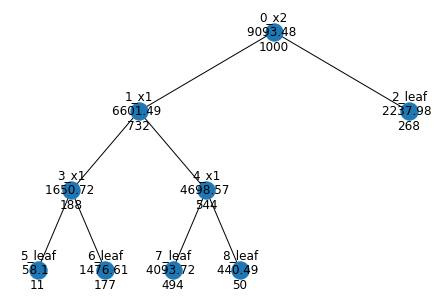

In [7]:
from Tree.tree_visualizer import TreeVisualizer
tree_vis = TreeVisualizer()
tree_vis.plot(kfold_gbm.trees[27].root)

## SKLEARN - One Hot

In [8]:
from sklearn.ensemble import GradientBoostingRegressor
clf = GradientBoostingRegressor(n_estimators=  N_ESTIMATORS, max_depth = MAX_DEPTH - 1,learning_rate = LEARNING_RATE)
clf.fit(pd.get_dummies(X), y)
pd.Series(clf.feature_importances_, index = pd.get_dummies(X).columns)

x1                   0.162734
x2                   0.832013
random_category_0    0.000174
random_category_1    0.000954
random_category_2    0.000359
random_category_3    0.000166
random_category_4    0.000805
random_category_5    0.000084
random_category_6    0.000845
random_category_7    0.000999
random_category_8    0.000069
random_category_9    0.000798
dtype: float64

## SKLEARN - Mean Imputing

In [9]:
category_to_mean = kfold_df[['random_category','y']].groupby('random_category')['y'].mean().to_dict()
X_m = X.copy()
X_m['random_category'] = X_m['random_category'].map(category_to_mean)
X_m['random_category'].astype('float')
clf = GradientBoostingRegressor(n_estimators=  N_ESTIMATORS, max_depth = MAX_DEPTH - 1,learning_rate = LEARNING_RATE)
clf.fit(X_m, y)
pd.Series(clf.feature_importances_, index = X_m.columns)

x1                 0.163170
x2                 0.832432
random_category    0.004398
dtype: float64

## XGBOOST - One Hot

In [10]:
!pip install xgboost

In [11]:
import xgboost as xgb

In [12]:
dtrain = xgb.DMatrix(pd.get_dummies(X), label=y)
param = {'max_depth': MAX_DEPTH - 1, 'eta': LEARNING_RATE, 'objective': 'reg:linear'}
num_round = N_ESTIMATORS
bst = xgb.train(param, dtrain, num_round)

[14:23:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


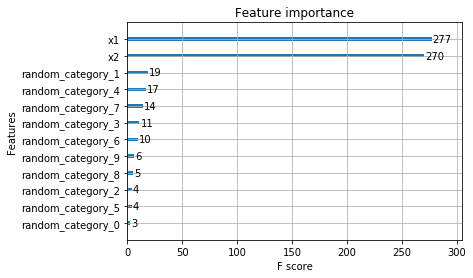

In [13]:
xgb.plot_importance(bst)
plt.show()

In [14]:
bst.get_score(importance_type='gain')

{'x2': 1020.4514642998137,
 'x1': 188.06953030493506,
 'random_category_1': 22.21283092736842,
 'random_category_4': 19.63437542352941,
 'random_category_3': 12.189232132727271,
 'random_category_7': 21.971091023571432,
 'random_category_6': 25.096224747,
 'random_category_9': 28.255637775,
 'random_category_0': 12.973506933333333,
 'random_category_5': 7.320858360000001,
 'random_category_2': 16.80569028,
 'random_category_8': 6.843447979999999}

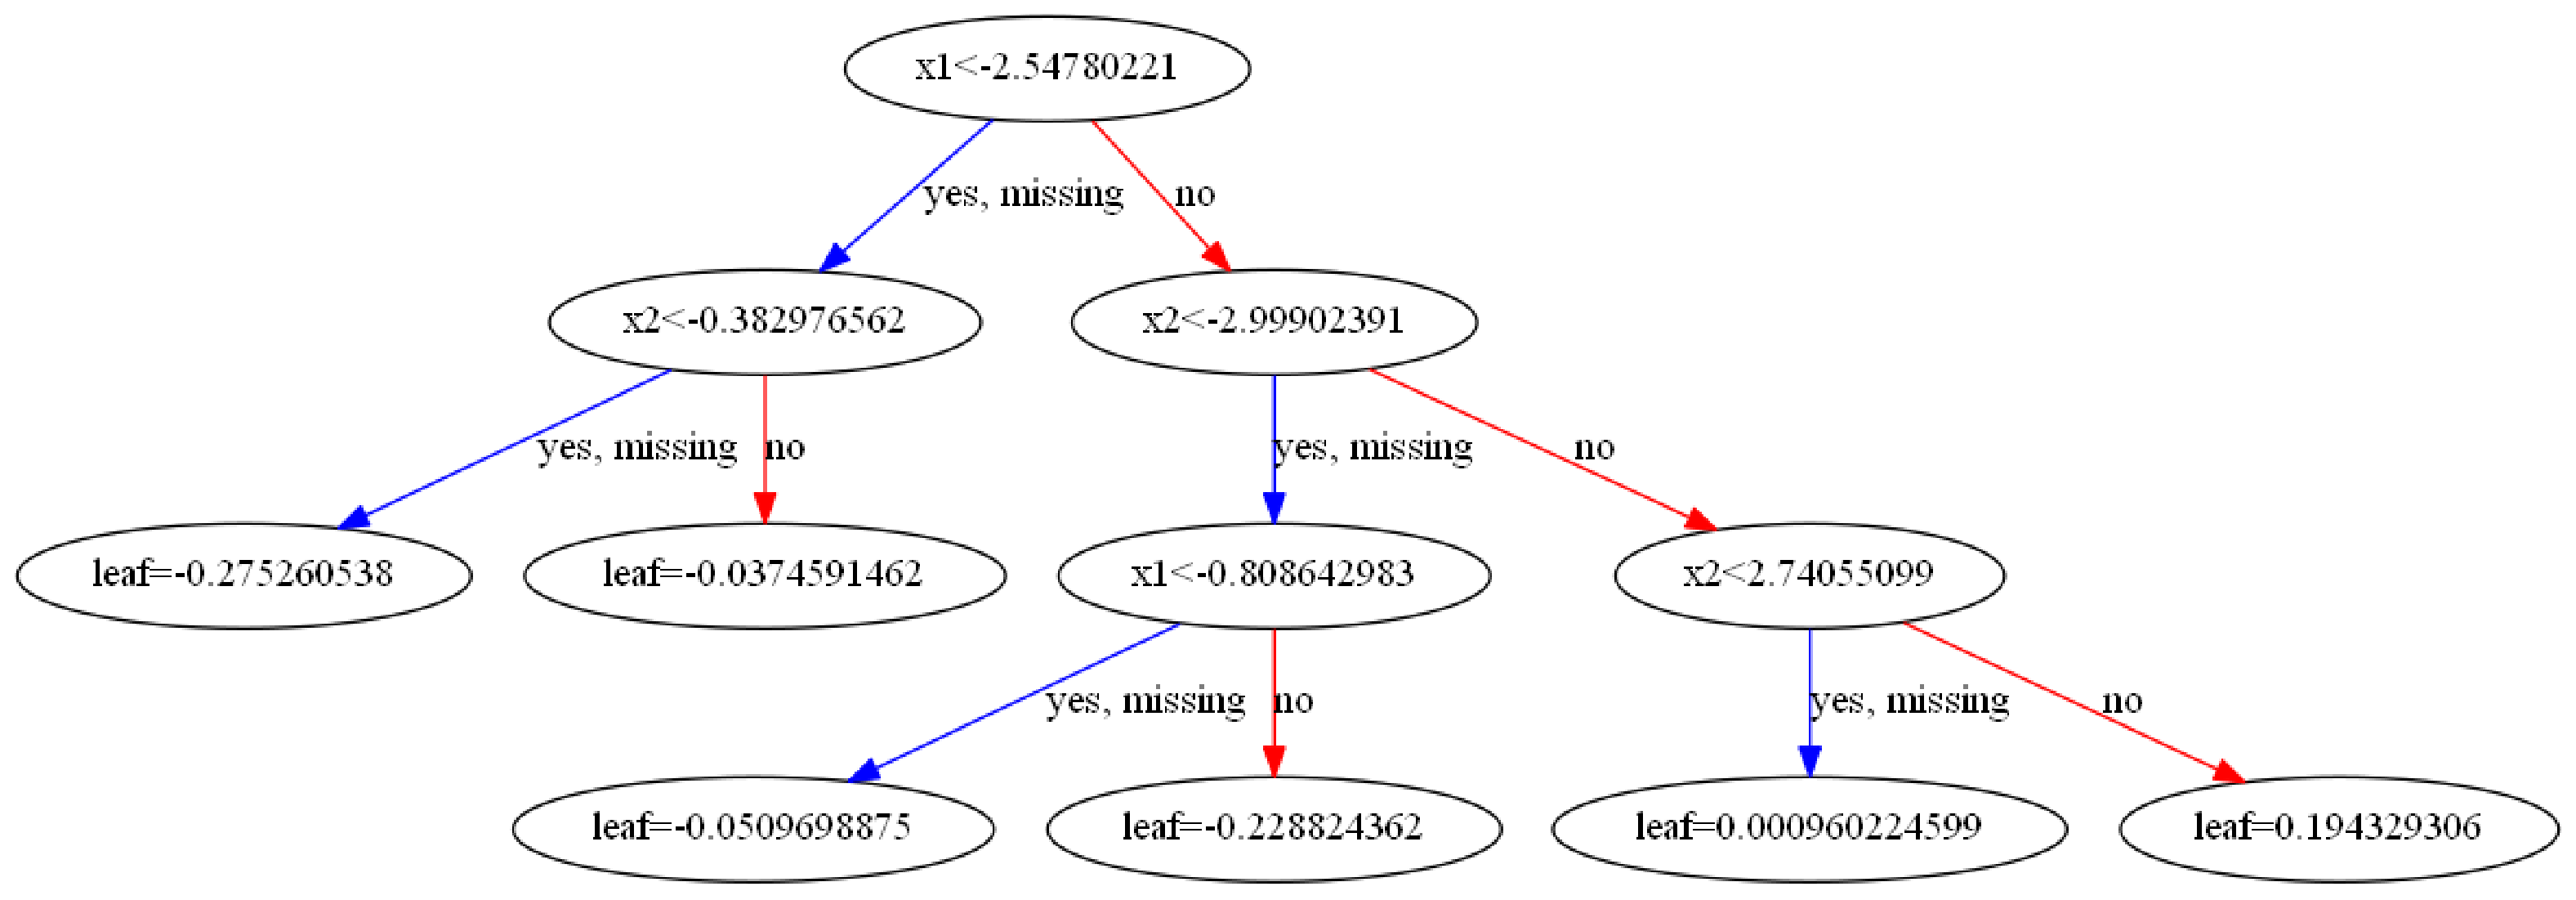

In [26]:
xgb.plot_tree(bst,num_trees= 58)
plt.rcParams['figure.figsize'] = [100, 20]
plt.show()

## XGBOOST - Mean Imputing

In [16]:
X_m['random_category'] = X_m['random_category'].astype('float')

In [17]:
dtrain = xgb.DMatrix(X_m, label=y)
param = {'max_depth': MAX_DEPTH - 1, 'eta': LEARNING_RATE, 'objective': 'reg:linear'}
num_round = N_ESTIMATORS
bst = xgb.train(param, dtrain, num_round)

[14:23:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


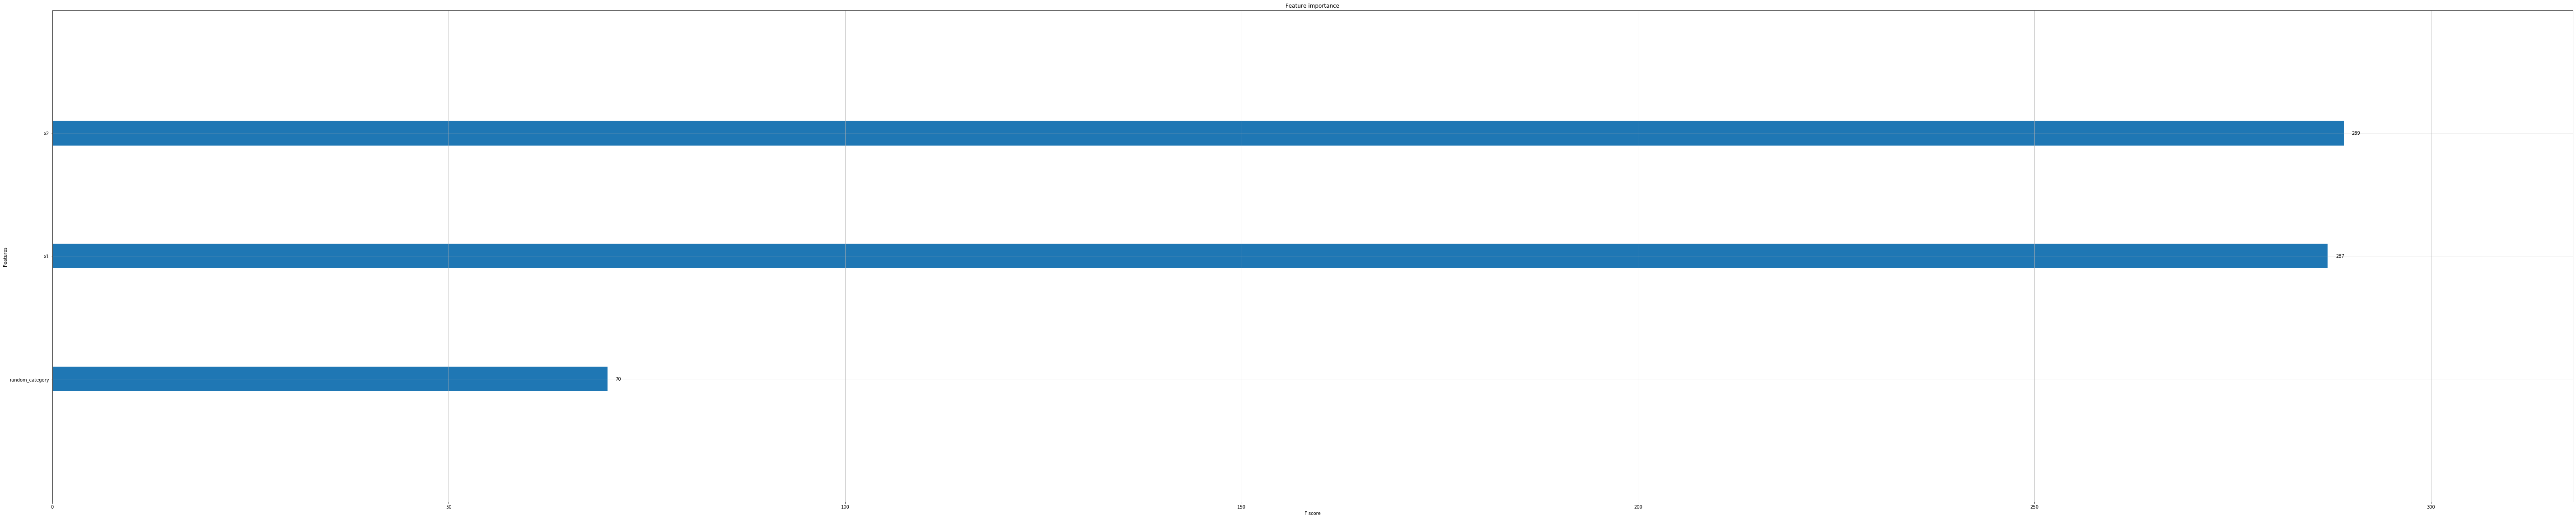

In [18]:
xgb.plot_importance(bst)
plt.show()

In [19]:
bst.get_score(importance_type='gain')

{'x2': 954.7844134821802,
 'x1': 180.64607389421622,
 'random_category': 21.43667269542857}

## Catboost

In [20]:
!pip install catboost

  Created wheel for retrying: filename=retrying-1.3.3-cp37-none-any.whl size=11435 sha256=0c7da99573c586c5af5e62c1bacbf7a336b8953c8d7aa4f13cf6a667efb6ae27
  Stored in directory: C:\Users\afeki\AppData\Local\pip\Cache\wheels\d7\a9\33\acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying


In [21]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [22]:
from catboost import Pool, CatBoostRegressor
# initialize data
# initialize Pool
train_pool = Pool(X, 
                  y, 
                  cat_features=[2])

# specify the training parameters 
model = CatBoostRegressor(iterations=100, 
                          depth=3, 
                          learning_rate=0.1, 
                          loss_function='RMSE')
#train the model
model.fit(train_pool)

0:	learn: 7.7601868	total: 192ms	remaining: 19s
1:	learn: 7.2871170	total: 195ms	remaining: 9.57s
2:	learn: 6.8729560	total: 208ms	remaining: 6.73s
3:	learn: 6.5148394	total: 216ms	remaining: 5.18s
4:	learn: 6.1605749	total: 217ms	remaining: 4.13s
5:	learn: 5.8945938	total: 219ms	remaining: 3.42s
6:	learn: 5.5931325	total: 220ms	remaining: 2.92s
7:	learn: 5.3229861	total: 221ms	remaining: 2.54s
8:	learn: 5.1088297	total: 222ms	remaining: 2.25s
9:	learn: 4.8964876	total: 223ms	remaining: 2.01s
10:	learn: 4.7023606	total: 225ms	remaining: 1.82s
11:	learn: 4.5343059	total: 226ms	remaining: 1.65s
12:	learn: 4.3872393	total: 226ms	remaining: 1.51s
13:	learn: 4.2561334	total: 227ms	remaining: 1.4s
14:	learn: 4.1380379	total: 228ms	remaining: 1.29s
15:	learn: 4.0351791	total: 229ms	remaining: 1.2s
16:	learn: 3.9549365	total: 229ms	remaining: 1.12s
17:	learn: 3.8855415	total: 230ms	remaining: 1.05s
18:	learn: 3.8103713	total: 231ms	remaining: 984ms
19:	learn: 3.7358255	total: 232ms	remaining: 

In [25]:
print(model.feature_names_)
model.feature_importances_

['x1', 'x2', 'random_category']


array([22.17160146, 77.62478671,  0.20361183])